# Homework 06 - Sebastiano Zagatti

In [1]:
!pip install torch
!pip install pyro-ppl

import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import Predictive
import torch.distributions.constraints as constraints

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

dataset = load_digits()
x, y = dataset.data, dataset.target
print("predictors shape =", x.shape)
print("labels shape =", y.shape)
print("n. unique labels =", len(np.unique(y)))

predictors shape = (1797, 64)
labels shape = (1797,)
n. unique labels = 10


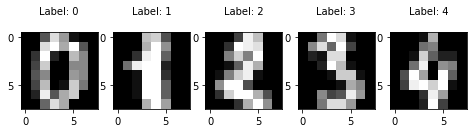

In [3]:
plt.figure(figsize=(8,3))
for index, (image, label) in enumerate(zip(x[0:5], y[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
 plt.title('Label: %i\n' % label, fontsize = 10)

1. Normalize the matrix of predictors and perform a train/test split using `train_test_split` from `sklearn` library

In [4]:
df = pd.DataFrame(data = dataset['data'], columns = dataset['feature_names'])
df = (df-df.min())/(df.max()-df.min())
df = df.fillna(0)
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,0.3125,0.8125,0.5625,0.0625,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.3750,0.8125,0.6250,0.0000,0.0000,0.0
1,0.0,0.0,0.0000,0.7500,0.8125,0.3125,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.6875,1.0000,0.6250,0.0000,0.0
2,0.0,0.0,0.0000,0.2500,0.9375,0.7500,0.0,0.0,0.0,0.0,...,0.3125,0.0,0.0,0.0,0.0000,0.1875,0.6875,1.0000,0.5625,0.0
3,0.0,0.0,0.4375,0.9375,0.8125,0.0625,0.0,0.0,0.0,0.5,...,0.5625,0.0,0.0,0.0,0.4375,0.8125,0.8125,0.5625,0.0000,0.0
4,0.0,0.0,0.0000,0.0625,0.6875,0.0000,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0000,0.1250,1.0000,0.2500,0.0000,0.0


In [5]:
features = torch.stack([torch.tensor(df[colname].values) for colname in df], dim=1)

x_train, x_test, y_train, y_test = train_test_split(features, dataset.target, test_size=0.2, random_state=1)

x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test.double(), dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([1437, 64]),
 torch.Size([360, 64]),
 torch.Size([1437]),
 torch.Size([360]))

2. Use pyro to write a multinomial bayesian logistic regression model. You should define both a `guide()` function and a `model()` function. Use a Categorical distribution on the outcomes to solve this multiclass classification
problem.

In [7]:
def model(x, y):
    n_observations, n_predictors = x.shape

    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors,10), torch.ones(n_predictors,10)).to_event(2))
    b = pyro.sample("b", dist.Normal(torch.zeros(10), torch.ones(10)).to_event(1))

    y_hat = torch.mm(x,w) + b

    sm = torch.softmax(y_hat, dim=-1)

    with pyro.plate("data", n_observations):
        y_final = pyro.sample("y_final", dist.Categorical(probs=sm), obs=y)
    
def guide(x, y):

    n_observations, n_predictors = x.shape

    w_loc = pyro.param("w_loc", torch.rand(n_predictors, 10))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors,10), constraint=constraints.positive)

    w = pyro.sample("w", dist.Normal(w_loc, w_scale).to_event(2))

    b_loc = pyro.param("b_loc", torch.rand(10))
    b_scale = pyro.param("b_scale", torch.rand(10), constraint=constraints.positive)

    b = pyro.sample("b", dist.Normal(b_loc, b_scale).to_event(1))

3. Run SVI inference using pyro `Adam` optimizer and plot the ELBO loss using `matplotlib.plot` function

In [8]:
svi = SVI(model = model, guide = guide, optim = pyro.optim.Adam({'lr': 0.02}), loss = Trace_ELBO())

Step 0 : loss = 4.7879189708287635
Step 1000 : loss = 0.535164639612993
Step 2000 : loss = 0.5043414938176102
Step 3000 : loss = 0.4617081206958163
Step 4000 : loss = 0.4927929531142541


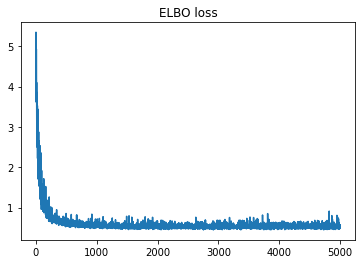

In [9]:
losses = []
for step in range(5000):
  loss = svi.step(x_train, y_train)/len(x_train)
  losses.append(loss)
  if step % 1000 == 0:
    print(f"Step {step} : loss = {loss}")
  
plt.title("ELBO loss")
plt.plot(losses)

4. Evaluate your model on the test data: compute the overall test accuracy and the class-wise accuracy for the 10
categories.

In [10]:
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

reshaped_w = inferred_w.reshape(inferred_w.shape[0]*inferred_w.shape[1],1)

In [11]:
def predict_class(x,w,b):
    n_observations, n_predictors = x.shape
    scores = torch.mm(x,w) + b.repeat(n_observations,1)
    probs = torch.softmax(scores, dim=-1)
    return torch.argmax(probs, dim=-1)

In [12]:
import pandas as pd

correct_predictions = (predict_class(x_test,inferred_w,inferred_b) == y_test).sum().item()
print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

y_test_df = pd.DataFrame(y_test, columns=["Target"])

for i in range(10):
    y_test_i = y_test_df.loc[y_test_df.Target == i]
    indices_class_i = y_test_i.index
    correct_predictions_i = (predict_class(x_test[indices_class_i,:],inferred_w,inferred_b) == y_test[indices_class_i]).sum().item()
    print(f"test accuracy over class {i} = {correct_predictions_i/len(x_test[indices_class_i])*100:.2f}%")

test accuracy = 98.61%
test accuracy over class 0 = 97.67%
test accuracy over class 1 = 100.00%
test accuracy over class 2 = 100.00%
test accuracy over class 3 = 100.00%
test accuracy over class 4 = 100.00%
test accuracy over class 5 = 96.67%
test accuracy over class 6 = 100.00%
test accuracy over class 7 = 97.30%
test accuracy over class 8 = 96.55%
test accuracy over class 9 = 97.06%
